In [6]:
import warnings
warnings.filterwarnings(action='once')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# https://stackoverflow.com/questions/22994423/difference-between-np-random-seed-and-np-random-randomstate
np.random.seed(18)
# np.random.RandomState(18)

In [7]:
import os
import sys
import os.path as path

In [8]:
# # mount gdrive and unzip data
# from google.colab import drive
# drive.mount('/content/gdrive')
# !unzip -q "/content/gdrive/My Drive/All_Datasets/hvc_data.zip"
# # look for `hvc_annotations.csv` file and `resized` dir
# %ls 

In [9]:
os.getcwd()

'D:\\Projects\\PersonAttributesData'

In [10]:
project_dir = '.'
data_dir = path.join(project_dir,'.')
url = path.join(data_dir, 'hvc_annotations.csv')

In [11]:
print(url)
path.exists(url)

.\.\hvc_annotations.csv


True

In [12]:
df = pd.read_csv(url)
df.drop('filename', axis=1, inplace = True)
df.head(2)

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg


In [13]:
df = df[:70]
df.shape

(70, 9)

In [14]:
df.shape

(70, 9)

In [15]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [16]:
one_hot_df.shape

(70, 27)

In [17]:
path.abspath(path.join(data_dir,'processed'))

'D:\\Projects\\PersonAttributesData\\processed'

In [18]:
# Custom batch generator
# -------
# Good one -  https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# https://towardsdatascience.com/image-augmentation-14a0aafd0498
# https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a    
# https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac
# https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

# Good one - https://www.kaggle.com/nikhilroxtomar/generators-for-keras-model


In [19]:
import keras
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator, img_to_array


# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]


class PersonDataGenerator(keras.utils.Sequence):
    """
    Ground truth data generator 

    https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
    """
    
    def __init__(self, df, batch_size = 32, input_size = (224, 224), 
                 location = '.', augmentations = None, save_dir = None,
                 shuffle = False):
        self.df = df
        self.image_size = input_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentations #ImageDataGenerator instance
        self.location = location
        self.save_dir =  save_dir # path.abspath(path.join(self.location,'processed'))
        self.on_epoch_end()

        if self.save_dir:
            self.save_dir = path.abspath(self.save_dir)
            if not path.isdir(self.save_dir):
                os.mkdirs(self.save_dir, exist_ok=True)

    def __len__(self):
        """
        Number of batch in the Sequence.
        """
        return int(np.floor(self.df.shape[0] / self.batch_size))

    
    def __getitem__(self, index):
        """
        Gets batch at position index.
        fetch batched images and targets        
        """
        # slice function - https://www.w3schools.com/python/ref_func_slice.asp
        
        
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]

        images = np.stack([cv2.imread(path.join(self.location, item["image_path"])) for _, item in items.iterrows()])        
#         if self.augmentation:
#             if self.save_dir:
#                 images = self.augmentation.flow(images, 
#                                             batch_size=self.batch_size, 
#                                             save_to_dir=self.save_dir,
#                                             save_prefix='aug').next()
                    
#             else:
        images = self.augmentation.flow(images, 
                                            batch_size=self.batch_size).next()


        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """
        Shuffles/sample the df and thereby 
        updates indexes after each epoch
        
        Method called at the end of every epoch.
        
        """
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            # frac --> take sample of the given df, sample size is given as fraction number
            # reset_index drop --> use the drop parameter to avoid the old index being added as a column
            # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
            

In [20]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.4, random_state=18)
train_df.shape, val_df.shape

((42, 27), (28, 27))

In [21]:
def blur(img):
    return (cv2.blur(img,(5,5)))

def get_random_eraser(input_img, p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img
    

def blur_cutout(img):
    img =blur(img)
    img = get_random_eraser(img)
    return img

train_aug = ImageDataGenerator(rescale=1/255.0,
                                        horizontal_flip=True,
                                        rotation_range=30,
                                        brightness_range=[0.2,0.8],
                                        channel_shift_range=100,
                                        preprocessing_function=blur_cutout
                                    )

val_aug = ImageDataGenerator(rescale=1/255.0)

In [22]:
# create train and validation data generators


train_gen = PersonDataGenerator(train_df, batch_size=32, 
                                input_size=(224, 224), location = data_dir, 
                                augmentations=train_aug, shuffle=True)

valid_gen = PersonDataGenerator(val_df, batch_size=32, 
                                input_size=(224, 224), location = data_dir, 
                                augmentations=val_aug)

In [23]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'gender': 2,
 'image_quality': 3,
 'age': 5,
 'weight': 4,
 'bag': 3,
 'pose': 3,
 'footwear': 3,
 'emotion': 3}

In [24]:
len(images)

32

In [3]:
# %tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

# from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


In [2]:
from keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.applications.resnet_v2 import ResNet152V2

Using TensorFlow backend.


In [26]:

backbone = ResNet152V2(include_top=False, weights=None,
                       input_tensor=Input(shape=(224, 224, 3)))

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    # redundant
#     neck = Dropout(0.2)(in_layer)
#     neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, incoming):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(incoming)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(necmodek))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [27]:
from keras.utils import plot_model
plot_model(model)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [ ]:
ResNet152V2(include_top=False, weights='None', input_shape=None, pooling=None)


In [ ]:
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape, name='input')

def separable(inputs, channels=32,name='', padding='valid', dropout=0.05, ):
    kernel_size=3
    
    filters=channels
    output = SeparableConv2D(filters, kernel_size, use_bias=False, padding=padding, name='separable_block'+name+'L1')(inputs)
    output = Activation('relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(dropout)(output)

    filters *= 2
    output = SeparableConv2D(filters, kernel_size, use_bias=False, padding=padding, name='separable_block'+name+'L1')(inputs)
    output = Activation('relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(dropout)(output)
    
    output = MaxPooling2D(2)(output)
    output = Conv2D(channles, 1, use_bias=False, name='separable_block'+name+'L3_Pointwise')(inputs)

    return output
def conv(inputs,channels=32,padding='valid' name='', dropout=0.05):
    kernel_size=3
    
    filters=channels
    output = Conv2D(filters, kernel_size, padding=padding, use_bias=False, name='Conv2D_'+name+'_L1')(inputs)
    output = Activation('relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(dropout)(output)
    
    filters *= 2 
    output = Conv2D(filters, kernel_size, padding=padding, use_bias=False, name='Conv2D_block'+name+'_L2')(inputs)
    output = Activation('relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(dropout)(output)
    
    output = MaxPooling2D(2)(output)
    output = Conv2D(channles, 1, use_bias=False, name='Conv2D_block'+name+'_L3_Pointwise')(inputs)

    return output


In [ ]:
# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


In [0]:
backbone = VGG16(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    # redundant
#     neck = Dropout(0.2)(in_layer)
#     neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, incoming):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(incoming)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = False

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
model_info = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=5,
    verbose=1
)

Epoch 1/5
2/2 [==============================] - 72s 36s/step - loss: 8.7825 - gender_output_loss: 0.9268 - image_quality_output_loss: 1.2556 - age_output_loss: 1.5120 - weight_output_loss: 1.1199 - bag_output_loss: 0.9973 - footwear_output_loss: 0.9843 - pose_output_loss: 1.1672 - emotion_output_loss: 0.8194 - gender_output_acc: 0.5156 - image_quality_output_acc: 0.3594 - age_output_acc: 0.3594 - weight_output_acc: 0.4531 - bag_output_acc: 0.5781 - footwear_output_acc: 0.5469 - pose_output_acc: 0.5625 - emotion_output_acc: 0.7812 - val_loss: 7.9409 - val_gender_output_loss: 0.8135 - val_image_quality_output_loss: 0.9337 - val_age_output_loss: 1.3870 - val_weight_output_loss: 1.1442 - val_bag_output_loss: 0.9503 - val_footwear_output_loss: 0.9574 - val_pose_output_loss: 0.9503 - val_emotion_output_loss: 0.8046 - val_gender_output_acc: 0.6719 - val_image_quality_output_acc: 0.4844 - val_age_output_acc: 0.5000 - val_weight_output_acc: 0.5156 - val_bag_output_acc: 0.5938 - val_footwear_ou

In [0]:
labels = [key for key, _ in targets.items()]
labels

['gender_output',
 'image_quality_output',
 'age_output',
 'weight_output',
 'bag_output',
 'pose_output',
 'footwear_output',
 'emotion_output']

In [0]:
import matplotlib.pyplot as plt

def plot_training_epochs(history, label):
  acc = label + '_acc'
  val_acc = 'val_' + label + '_acc'

  loss = label + '_loss'
  val_loss = 'val_' + label + '_loss'
  # summarize history for accuracy
  plt.plot(history.history[acc], label='train_acc')
  plt.plot(history.history[val_acc], label='val_acc')
  plt.title(label)
  plt.xlabel('epoch')

  # summarize history for loss
  plt.plot(history.history[loss], label='train_loss')
  plt.plot(history.history[val_loss], label='val_loss')
  plt.legend(loc='upper left')
  plt.show()

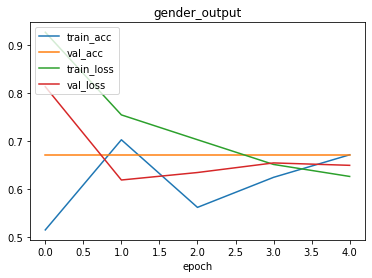

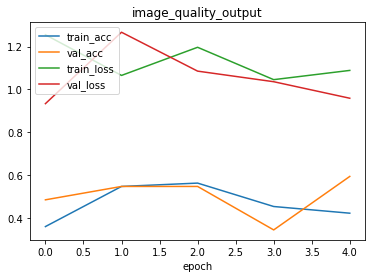

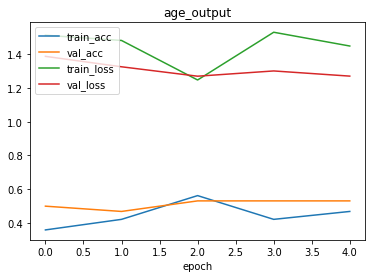

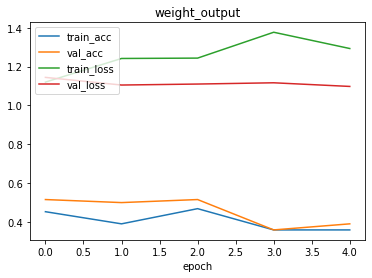

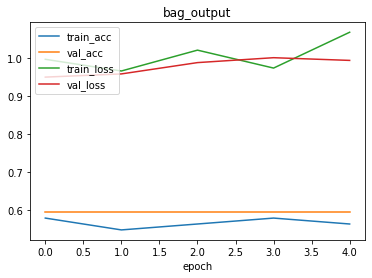

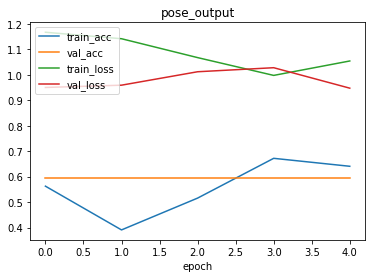

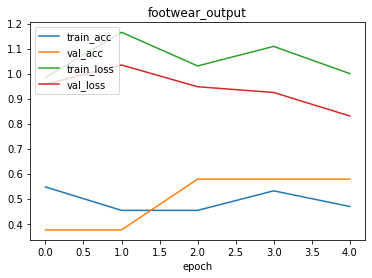

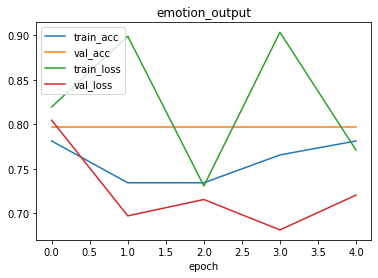

In [0]:
for label in labels:
  plot_training_epochs(model_info, label)

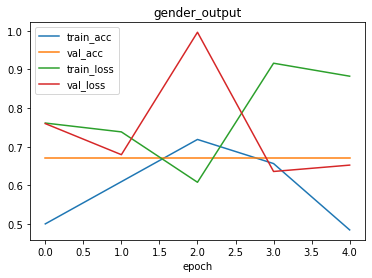

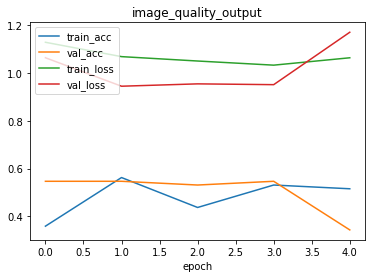

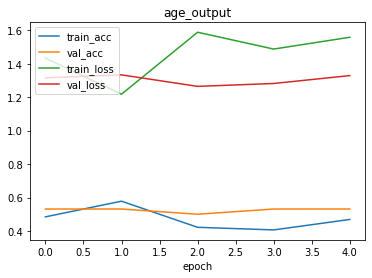

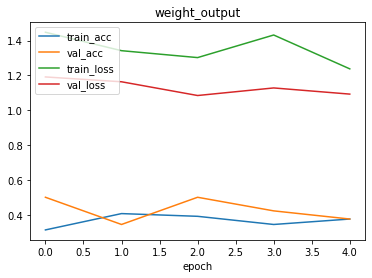

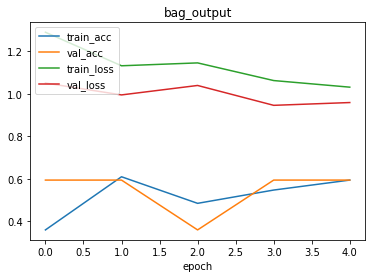

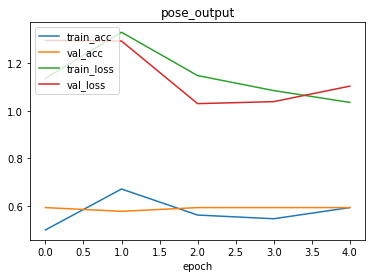

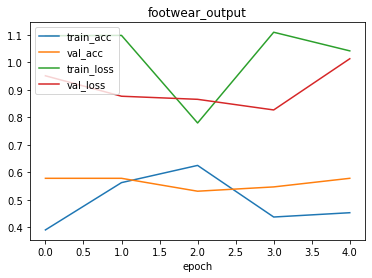

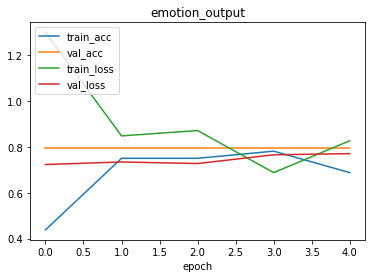

In [0]:
for label in labels:
  plot_training_epochs(model_info, label)

2/2 [==============================] - 33s 17s/step


In [0]:
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

{'age_output_acc': 0.53125,
 'age_output_loss': 1.2789743542671204,
 'bag_output_acc': 0.59375,
 'bag_output_loss': 0.9790736436843872,
 'emotion_output_acc': 0.796875,
 'emotion_output_loss': 0.7136271744966507,
 'footwear_output_acc': 0.578125,
 'footwear_output_loss': 0.8436903655529022,
 'gender_output_acc': 0.671875,
 'gender_output_loss': 0.6455998420715332,
 'image_quality_output_acc': 0.390625,
 'image_quality_output_loss': 0.9853080809116364,
 'loss': 7.494219779968262,
 'pose_output_acc': 0.59375,
 'pose_output_loss': 0.9632466435432434,
 'weight_output_acc': 0.484375,
 'weight_output_loss': 1.0846996307373047}

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

In [0]:
def lr_schedule(epoch):
  lr = round(0.003 * pow(0.5, epoch//2), 10) #  halving lr every 2 epochs
  print ('Learning rate is : ', lr)
  return lr

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'vgg_hvc_1_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir, exist_ok=True)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [0]:
model_info = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=5,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/5
Learning rate is :  0.003
2/2 [==============================] - 73s 37s/step - loss: 7.9712 - gender_output_loss: 0.6738 - image_quality_output_loss: 0.9946 - age_output_loss: 1.5199 - weight_output_loss: 1.1639 - bag_output_loss: 1.0272 - footwear_output_loss: 1.0503 - pose_output_loss: 0.8667 - emotion_output_loss: 0.6748 - gender_output_acc: 0.6250 - image_quality_output_acc: 0.4375 - age_output_acc: 0.3594 - weight_output_acc: 0.3750 - bag_output_acc: 0.5469 - footwear_output_acc: 0.4688 - pose_output_acc: 0.6719 - emotion_output_acc: 0.8125 - val_loss: 7.7349 - val_gender_output_loss: 0.6209 - val_image_quality_output_loss: 1.0731 - val_age_output_loss: 1.3265 - val_weight_output_loss: 1.1234 - val_bag_output_loss: 0.9603 - val_footwear_output_loss: 0.9442 - val_pose_output_loss: 0.9835 - val_emotion_output_loss: 0.7030 - val_gender_output_acc: 0.6719 - val_image_quality_output_acc: 0.5469 - val_age_output_acc: 0.3750 - val_weight_output_acc: 0.5000 - val_bag_output_acc

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2/2 [==============================] - 69s 34s/step - loss: 8.2922 - gender_output_loss: 0.7524 - image_quality_output_loss: 1.1890 - age_output_loss: 1.3438 - weight_output_loss: 1.3020 - bag_output_loss: 0.9999 - footwear_output_loss: 0.9917 - pose_output_loss: 1.0261 - emotion_output_loss: 0.6872 - gender_output_acc: 0.5000 - image_quality_output_acc: 0.5156 - age_output_acc: 0.4375 - weight_output_acc: 0.5156 - bag_output_acc: 0.5469 - footwear_output_acc: 0.4375 - pose_output_acc: 0.6094 - emotion_output_acc: 0.7969 - val_loss: 7.5471 - val_gender_output_loss: 0.6441 - val_image_quality_output_loss: 0.9723 - val_age_output_loss: 1.3152 - val_weight_output_loss: 1.1281 - val_bag_output_loss: 0.9529 - val_footwear_output_loss: 0.8526 - val_pose_output_loss: 0.9523 - val_emotion_output_loss: 0.7295 - val_gender_output_acc: 0.6719 - val_image_quality_output_acc: 0.5469 - val_age_output_acc: 0.5312 - val_weight_output_acc: 0.3281 - val_bag_output_acc: 0.5938 - val_footwear_output_acc: 

In [0]:
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

2/2 [==============================] - 33s 16s/step


{'age_output_acc': 0.53125,
 'age_output_loss': 1.2733455300331116,
 'bag_output_acc': 0.59375,
 'bag_output_loss': 0.9530223309993744,
 'emotion_output_acc': 0.796875,
 'emotion_output_loss': 0.7359009385108948,
 'footwear_output_acc': 0.578125,
 'footwear_output_loss': 0.8264914453029633,
 'gender_output_acc': 0.671875,
 'gender_output_loss': 0.6314684748649597,
 'image_quality_output_acc': 0.546875,
 'image_quality_output_loss': 0.9932706952095032,
 'loss': 7.452946901321411,
 'pose_output_acc': 0.59375,
 'pose_output_loss': 0.9742444157600403,
 'weight_output_acc': 0.5,
 'weight_output_loss': 1.0652029514312744}

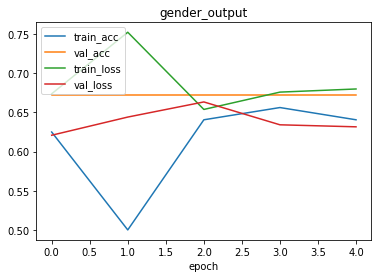

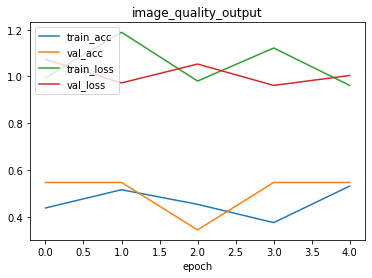

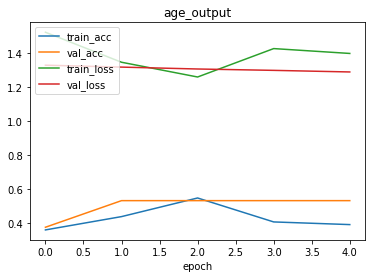

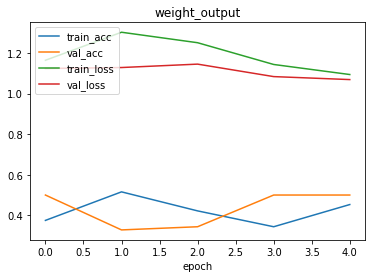

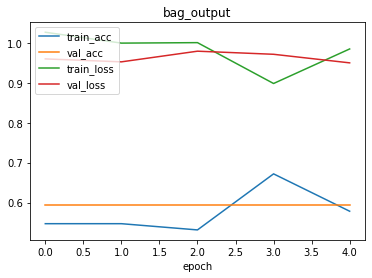

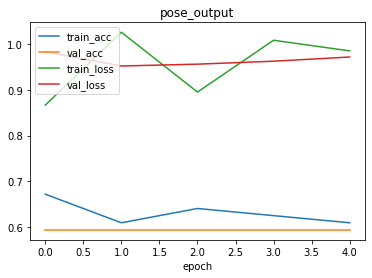

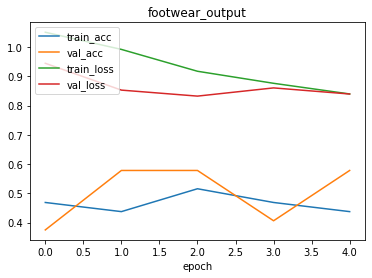

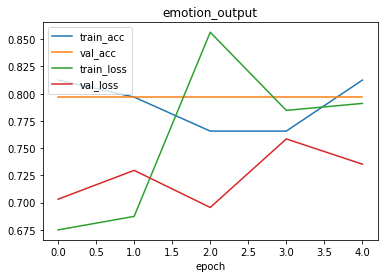

In [0]:
for label in labels:
  plot_training_epochs(model_info, label)

In [0]:


# # checking some random images
# fig = plt.figure(figsize=(10,5))
# for i in range(num_classes):
#   ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
#   idx = np.where(y_train[:]==i)[0] # selecting image_idx of single class
#   features = x_train[idx,::]
#   img_num = np.random.randint(features.shape[0])
#   im = features[img_num]
#   ax.set_title(class_names[i])
#   plt.imshow(im)
# plt.show()


# # display n random images for each class
# n = 10
# r, c = 10, n
# fig = plt.figure(figsize=(10,10))
# fig.subplots_adjust(hspace=0.01, wspace=0.01)
# for i in range(num_classes):
#     idx = np.random.choice(np.where(y_train[:]==i)[0], c, replace=False)
#     ax = plt.subplot(r, c, i*c+1)
#     ax.text(-1.5, 0.5, class_names[i], fontsize=14)
#     plt.axis('off')
#     for j in range(1, c):
#       plt.subplot(r, c, i*c+j+1)
#       plt.imshow(x_train[idx[j-1]], interpolation='none')
#       plt.axis('off')
# plt.show()

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # list of DeviceAttributes

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2785027350564102718
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4951913267
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4807772686025660392
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [0]:
import tensorflow as tf
tf.test.is_gpu_available() # True/False

True

In [0]:
# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 

True

In [0]:
a = np.random.uniform(low=0, high=255, size=(10,32,32,3))

In [0]:
a

array([[[[1.27585603e+02, 3.25460126e+01, 7.79283066e+01],
         [1.70839082e+02, 1.57297408e-01, 3.86185582e+01],
         [1.76328884e+02, 1.54596652e+02, 2.33121628e+02],
         ...,
         [2.31363788e+02, 5.71377869e+00, 7.16094464e+01],
         [2.23426236e+02, 1.55311589e+01, 1.24620324e+02],
         [1.54591580e+02, 2.16731602e+02, 2.15383715e+02]],

        [[2.44851704e+02, 3.24262800e+01, 6.03719302e+01],
         [1.03985182e+02, 1.64772514e+02, 1.79673482e+02],
         [2.17943032e+02, 1.25824198e+02, 5.00939881e+00],
         ...,
         [2.11637380e+02, 1.47452629e+02, 2.07640810e+02],
         [4.95952850e+01, 1.62173611e+02, 4.79476001e+01],
         [1.75768877e+02, 3.95225851e+01, 2.16237439e+02]],

        [[6.06966513e+01, 2.47324812e+02, 1.92106703e+02],
         [4.36843349e+01, 2.46826788e+02, 2.17501069e+02],
         [1.99176266e+02, 2.10746780e+02, 1.39805801e+02],
         ...,
         [6.01348524e+01, 4.99465160e+01, 1.65431186e+02],
         [

In [0]:
a = a/255.0

In [0]:
a

array([[[[5.00335700e-01, 1.27631422e-01, 3.05601202e-01],
         [6.69957183e-01, 6.16852580e-04, 1.51445326e-01],
         [6.91485818e-01, 6.06261382e-01, 9.14202461e-01],
         ...,
         [9.07308973e-01, 2.24069753e-02, 2.80821358e-01],
         [8.76181317e-01, 6.09065054e-02, 4.88707155e-01],
         [6.06241489e-01, 8.49927852e-01, 8.44642019e-01]],

        [[9.60202760e-01, 1.27161883e-01, 2.36752668e-01],
         [4.07785029e-01, 6.46166722e-01, 7.04601892e-01],
         [8.54678555e-01, 4.93428226e-01, 1.96447012e-02],
         ...,
         [8.29950509e-01, 5.78245604e-01, 8.14277684e-01],
         [1.94491314e-01, 6.35974947e-01, 1.88029804e-01],
         [6.89289715e-01, 1.54990530e-01, 8.47989958e-01]],

        [[2.38026084e-01, 9.69901223e-01, 7.53359618e-01],
         [1.71311117e-01, 9.67948188e-01, 8.52945369e-01],
         [7.81083396e-01, 8.26457959e-01, 5.48258045e-01],
         ...,
         [2.35822951e-01, 1.95868690e-01, 6.48749749e-01],
         [

In [215]:
class PersonDataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, aug_list=[], incl_orig=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
        self.aug_list = aug_list
        self.incl_orig = incl_orig
        self.orig_len = int(np.floor(self.df.shape[0] / self.batch_size))

    def __len__(self):
        if self.incl_orig:
            delta = 1
        else:
            delta = 0
#         print('values of self.df.shape[0], self.batch_size,  self.orig_len, len(self.aug_list), delta', self.df.shape[0], self.batch_size,  self.orig_len, len(self.aug_list), delta)
#         print('len : ', self.orig_len * (len(self.aug_list) + delta))
        return self.orig_len * (len(self.aug_list) + delta)

    def __getitem__(self, index):
        if not self.incl_orig :
            index += self.orig_len - 1

#         print('Index : ', index)
#         print('self.orig_len : ', self.orig_len)
        
        if index > self.orig_len - 1:
            aug = self.aug_list[index // self.orig_len - 1]
            index %= self.orig_len
#             print('Inside if condition - aug_ele : ', (index // self.orig_len - 1), self.aug_list[index // self.orig_len - 1])
        else:
            aug = None

#         print('Index : ', index)
        
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])        
        
        if aug is not None:
            images = aug.flow(images, shuffle=False).next()
#             print('Augmentation is done')
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target
    def on_epoch_end(
self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [216]:
train_gen = PersonDataGenerator(
    train_df, 
    batch_size=32, 
    aug_list=[
        ImageDataGenerator(rotation_range=45),
        ImageDataGenerator(horizontal_flip=True),
        ImageDataGenerator(vertical_flip=True),
    ],
    incl_orig=True,  # Whether to include original images
)


In [217]:
len(train_gen)

1016

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


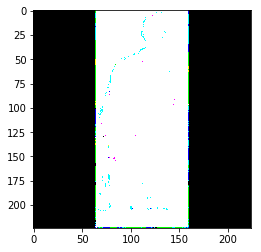

In [233]:
plt.imshow(train_gen[1000][0][0])
# train_gen[0][0][0].shape

In [190]:
images_ge, targets = next(iter(train_gen))

values of self.df.shape[0], self.batch_size,  self.orig_len, len(self.aug_list), delta 8143 32 254 3 1
len :  1016
Index :  0
self.orig_len :  254
Index :  0


In [147]:
images_ge, targets = next(iter(train_gen))

values of self.df.shape[0], self.batch_size,  self.orig_len, len(self.aug_list), delta 8143 32 254 3 0
Index :  253
self.orig_len :  254
Index :  253


In [148]:
len(images_ge)

32